# Sine wave example using IF and RRCF

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import IsolationForest

import sklearn.metrics as met

import rrcf
from rrcf.shingle import shingle

## Generate and shingle data

In [2]:
n = 730
A = 50
center = 100
phi = 30
T = 2*np.pi/100
t = np.arange(n)
sin = A*np.sin(T*t-phi*T) + center
sin[235:255] = 80

labels = np.zeros(len(sin))
labels[235:255] = 1

In [3]:
parmas = {"trees" : 100}
data_dim = 4
data_index = []

data_stream = shingle(sin, data_dim)
sin_shingle = np.asarray(next(data_stream))
for i in range(1,len(sin)-data_dim+1):
    sin_shingle = np.vstack((sin_shingle, next(data_stream)))

## Establish and run IF algorithm

IF, Sample size: 256
Positive Precision: 0.425
Positive Recall   : 0.85
Negative Precision: 0.9956331877729258
Negative Recall   : 0.9674681753889675
Accuracy          : 0.9642365887207703



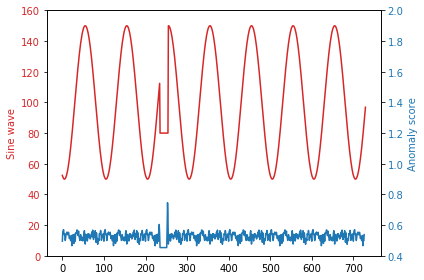

In [4]:
data = sin
data_shingle = sin_shingle
sample_size = 256
IF = IsolationForest(n_estimators = parmas["trees"],
                max_samples = sample_size,
                contamination = 'auto',
                behaviour = 'new',
                random_state = 42)
sample = np.random.choice(len(data_shingle),sample_size)
IF.fit(data_shingle[sample,:])

if_score = -1*IF.score_samples(data_shingle)
if_perf = IF.fit_predict(data_shingle)
if_perf[if_perf < 0] = 0

# Compute performance metrics
tn, fp, fn, tp = met.confusion_matrix(labels[data_dim-1:], if_perf).ravel()
ppv = tp /(tp + fp)
precall = tp /(tp + fn)

npv = tn /(tn + fn)
nrecall = tn /(tn + fp)

acc = (tp + tn) / (tp+tn+fp+fn)

print('IF, Sample size: ' + str(sample_size))
print("Positive Precision:", ppv)
print("Positive Recall   :", precall)
print("Negative Precision:", npv)
print("Negative Recall   :", nrecall)
print("Accuracy          :", acc)
print()

# Color detected anomalies in red
colors = np.array(['#000000', '#ff0000'])
#plt.figure()
#plt.scatter(np.linspace(0,len(data)-1,len(data)), data, s=10, color=colors[if_perf])

fig, ax1 = plt.subplots()

colorY1 = 'tab:red'
ax1.set_ylabel('Sine wave', color=colorY1)
ax1.plot(data, color=colorY1)
ax1.tick_params(axis='y', labelcolor=colorY1)
ax1.set_ylim(0.,160.)

ax2 = ax1.twinx()

colorY2 = 'tab:blue'
ax2.set_ylabel('Anomaly score', color=colorY2)
ax2.plot(if_score, color=colorY2)
ax2.tick_params(axis='y', labelcolor=colorY2)
ax2.set_ylim(0.4,2.)
    
fig.tight_layout()
plt.show()

# Random Forest

In [6]:
# make the inital trees
forest = [rrcf.RCTree(sin_shingle[0:3,:]) for i in range(0, parmas["trees"])]
# add 3 data points
data_index = [0, 1, 2]
codisp = np.zeros((len(sin), parmas["trees"]))

for tree in forest:
    codisp[1, forest.index(tree)] = tree.codisp(1)
    codisp[2, forest.index(tree)] = tree.codisp(2)

for i in range(3, len(sin_shingle)):
    if len(data_index) >= sample_size:
        # forget the point
        for tree in forest:
            tree.forget_point(data_index[0])
        data_index.pop(0)

    data_index.append(i+3)
    # insert the new point
    d = sin_shingle[i]
    for tree in forest:
        tree.insert_point(np.asarray(d), data_index[-1])
        # compute the codisp
        codisp[i, forest.index(tree)] = tree.codisp(data_index[-1])

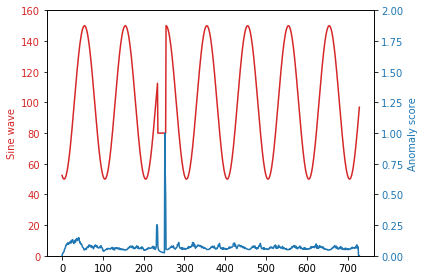

In [8]:
fig, ax1 = plt.subplots()

colorY1 = 'tab:red'
ax1.set_ylabel('Sine wave', color=colorY1)
ax1.plot(data, color=colorY1)
ax1.tick_params(axis='y', labelcolor=colorY1)
ax1.set_ylim(0.,160.)

ax2 = ax1.twinx()

colorY2 = 'tab:blue'
ax2.set_ylabel('Anomaly score', color=colorY2)
ax2.plot(codisp.mean(axis=1)/max(codisp.mean(axis=1)), color=colorY2)
ax2.tick_params(axis='y', labelcolor=colorY2)
ax2.set_ylim(0.0,2.)
    
fig.tight_layout()
plt.show()

In [9]:
np.save("codisp_sin_rrcf.npy", codisp.mean(axis=1))
np.save("socre_sin_if.npy", if_score)
np.save("sin.npy", data)